In [3]:
!pip install sentence-transformers
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=654ef2cbc605b71f4b051787f770e9ac0a4c3c8199208a0b5639a34861b5ba87
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

from string import digits
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from tqdm import tqdm, notebook
from sentence_transformers import SentenceTransformer, models, util

import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/youtube-comments-categorization/youtube-comments-categorization.csv


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig

In [7]:
import os
import random
import gc
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
sns.set(style='darkgrid')

from sklearn.model_selection import train_test_split

%matplotlib inline

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 97
seed_everything(SEED)

Device:  cpu


In [9]:
cfg = {}
DISTIL_BERT = 'distilbert-base-uncased'
MODEL_PATH = DISTIL_BERT

In [10]:
df = pd.read_csv('/kaggle/input/youtube-comments-categorization/youtube-comments-categorization.csv', header = None)
df.columns = ['comment', 'label']
df.head()

,comment,label
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,miscellaneous


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  10000 non-null  object
 1   label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


/tmp/ipykernel_32/276136780.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=45)


<Axes: xlabel='label', ylabel='count'>

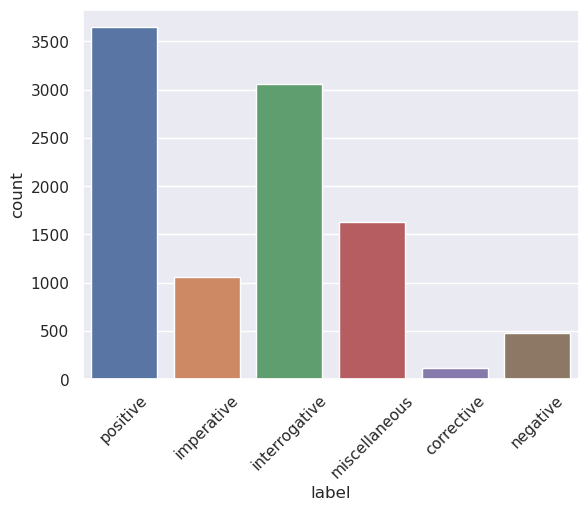

In [12]:
_, ax = plt.subplots()
labels = df.label.unique()
ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x='label', data=df, ax=ax)

In [13]:
df.label.unique()
labels = {'positive':0, 'imperative':1, 'interrogative':2, 'miscellaneous':3,
       'corrective':4, 'negative':5}
df['enc_label'] = df.label.apply(lambda x: labels[x])
df.head()

,comment,label,enc_label
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,imperative,1
2,I bought both of your courses on Udemy. You ar...,interrogative,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,miscellaneous,3


In [14]:
X_ignore, X_temp, y_ignore, y_temp = train_test_split(df.comment, df.enc_label, test_size=0.3, random_state=SEED, stratify=df.enc_label)
X_train, X_temp2, y_train, y_temp2 = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=SEED, stratify=y_temp2)

In [15]:
len(X_train), len(X_val), len(X_test)

(2400, 300, 300)

In [16]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [17]:
train_df.head()

,comment,enc_label
0,Depending in india 250 dollar will be how much...,2
1,Great Presentation skills...Keep on keeping on.,0
2,"but the algorithm only applies when m<1 ,let m...",1
3,Thanks,0
4,"Finally great advice, I always use to think ab...",0


In [18]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [19]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 3
cfg['learning_rate'] = 1e-05

In [20]:
class CommentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'comment']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'enc_label']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [21]:
train_data = CommentsDataset(train_df, tokenizer, cfg['max_length'])
val_data = CommentsDataset(val_df, tokenizer, cfg['max_length'])
test_data = CommentsDataset(test_df, tokenizer, cfg['max_length'])

In [22]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [23]:
class CommentRelevanceBERT(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(CommentRelevanceBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name
        
        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == DISTIL_BERT:
            self.in_features = self.bert.transformer.layer[5].output_layer_norm.normalized_shape[0]
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        # self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == DISTIL_BERT:
            last_hidden_state = self.bert(input_ids,
                                          attention_mask=attention_mask,
                                          return_dict=False)
            first_token_tensor = last_hidden_state[0][:, 0]
            output = self.dense(first_token_tensor)
            output = self.activation(output)
            
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        # output = self.dropout(output)
        output = self.classifier(output)
        return output

In [24]:
model = CommentRelevanceBERT(MODEL_PATH)
model.to(device)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

OSError: distilbert-base-uncased does not appear to have a file named pytorch_model.bin but there is a file for TensorFlow weights. Use `from_tf=True` to load this model from those weights.

In [ ]:
from torch.optim.lr_scheduler import StepLR
from transformers import get_cosine_schedule_with_warmup

In [ ]:
num_training_steps = cfg['epochs']*len(train_loader)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [ ]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy